**Analyzing World Bank's** ***Health, Population and Nutrition*** **data to identify indices relevant for maternal-child survival**

In [1]:
import numpy as np
import pandas as pd
import pandas_gbq as pd_gbq #integrates Pandas with Google BigQuery data warehouse's client library for Python.

Write SQL code to read series_code, topic, indicator_name and short_definition from the BigQuery data file
*bigquery-public-data.world_bank_health_population.series_summary*:

In [2]:
get_indicator_codes = """
SELECT
    series_code, topic, indicator_name, short_definition
FROM
    `bigquery-public-data.world_bank_health_population.series_summary`
"""

Perform the query and load the result to a Pandas dataframe
(that achieves the same results as the following 3 lines of code  
"""  
from google.cloud import bigquery  
client = bigquery.Client()  
indicator_codes_data_frame = client.query(get_indicator_codes).to_dataframe()  
"""  
which does not use pandas_gbq):

In [3]:
#indicator_codes_data = pd.read_gbq(get_indicator_codes,project_id='world-dev-indc')
#indicator_codes_data.to_csv(r'./indicator_codes_data.csv')

Read the CSV file as a dataframe:

In [4]:
indicator_codes = pd.read_csv("indicator_codes_data.csv") 

Manually scan through indicator names and descriptions and then select indicators that have a bearing on infant, child and maternal mortality:

In [5]:
indicator_codes_select=[1,2,4,5,7,21,22,26,27,28,29,31,32,36,37,38,41,44,46,48,49,51,57,59,
                      60,61,62,63,64,71,76,78,92,95,101,102,103,104,105,106,107,108,112,117,118,119,120,
                      121,122,144,145,146,147,154,157,160,164,171,172,173,182,190,192,193,197,
                      202,262,264,267,269,270,271,277,278,279,281,282,283,293,298,300,
                      302,304,306,327,331,332,338,341,344,347,350]

In [6]:
for i in [1,2,4]:
    print(i, indicator_codes.iloc[i,1])
    # gives the same result as print(i, indicator_codes['series_code'][i])

1 SH.PRG.SYPH.ZS
2 SH.UHC.SRVS.CV.XD
4 SH.STA.IYCF.ZS


Define an array with indicator codes and an array with country names for later:

In [7]:
attributes = ["Serial No."]
attributes.append("Country_Name") 
for i in indicator_codes_select:
    attributes.append(indicator_codes.iloc[i,1]) 
attributes[:5]

['Serial No.',
 'Country_Name',
 'SH.PRG.SYPH.ZS',
 'SH.UHC.SRVS.CV.XD',
 'SH.STA.IYCF.ZS']

In [8]:
df = pd.read_csv("country_names.csv", usecols = ['country_name'])
df[:5]

,country_name
0,Brunei Darussalam
1,Cayman Islands
2,Sint Maarten (Dutch part)
3,South Africa
4,Uruguay


Write a function that returns SQL query with indicator names of given index i as search criteria. Avergage over the available annual data since 2010:

In [9]:
def get_indicator_values(i):
    return ("""
    SELECT
      country_name,
      AVG(value) AS average
    FROM
      `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE
      indicator_code = \""""+indicator_codes.iloc[i,1]+"""\"
      AND year > 2010
    GROUP BY
      country_name
    ;
        """)

Read indicator values form *bigquery-public-data.world_bank_health_population.health_nutrition_population* and merge with the dataframe containing country names:

In [10]:
#for i in indicator_codes_select:
#    df1 = pd.read_gbq(get_indicator_values(i),project_id='world-dev-indc')
#    df = pd.merge(df, df1, left_on='country_name', right_on='country_name', how='outer')
#df.to_csv(r'./maternal_child_health.csv')

In [11]:
mch = pd.read_csv("maternal_child_health.csv", float_precision = "round_trip")
mch.columns = attributes
mch = mch.drop(columns=["Serial No."])
#mch = mch.set_index("Country_Name")
mch[:5]

,Country_Name,SH.PRG.SYPH.ZS,SH.UHC.SRVS.CV.XD,SH.STA.IYCF.ZS,SH.STA.PNVC.ZS,SH.STA.OWAD.FE.ZS,SH.UHC.OOPC.25.ZS,SP.DYN.CBRT.IN,SH.FPL.SATM.ZS,SH.MED.BEDS.ZS,...,SP.POP.3539.FE,SP.POP.4044.FE,SP.POP.TOTL.FE.IN,SP.DYN.TFRT.IN,SP.POP.TOTL,SH.STA.MALN.ZS,SH.STA.OWGH.ZS,SH.STA.STNT.ZS,SH.STA.WAST.ZS,SH.SVR.WAST.ZS
0,Brunei Darussalam,0.30,1.0,NaN,NaN,39.816667,NaN,16.356375,NaN,2.73,...,1.0,1.0,1.0,1.933500,1.0,NaN,NaN,NaN,NaN,NaN
1,Cayman Islands,NaN,NaN,NaN,NaN,NaN,NaN,11.833501,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,Sint Maarten (Dutch part),NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,...,NaN,NaN,NaN,2.030000,1.0,NaN,NaN,NaN,NaN,NaN
3,South Africa,1.60,1.0,1.0,83.6,64.050000,NaN,21.869875,77.8,NaN,...,1.0,1.0,1.0,2.495875,1.0,7.2,15.25,27.3,4.05,1.85
4,Uruguay,1.04,1.0,NaN,NaN,50.016667,NaN,14.123750,NaN,2.20,...,1.0,1.0,1.0,1.995500,1.0,1.0,7.20,10.7,1.30,1.00


Count the proportion of NaNs:

In [12]:
mch.isna().sum().sum() / (len(mch.index)*(len(mch.columns)-1)) #because one of the columns is country names!

0.3187141894169194

Drop countries/territories/groups that have more than half the data missing:

In [13]:
to_drop = []
for i in range(len(mch.index)):
    if (mch.iloc[i].count() < len(mch.columns)/2):
        to_drop.append(i)
mch = mch.drop(to_drop,axis=0)
mch = mch.reset_index(drop=True)

In [14]:
mch.isna().sum().sum() / (len(mch.index)*(len(mch.columns)-1))

0.24509899068322982

Drop columns that have missing data for more than half the countries/territories:

In [15]:
to_drop = []
for i in range(1,len(mch.columns)):
    if (mch[mch.columns[i]].count() < len(mch.index)/2):
        to_drop.append(mch.columns[i])
mch = mch.drop(to_drop,axis=1)
mch

,Country_Name,SH.PRG.SYPH.ZS,SH.UHC.SRVS.CV.XD,SH.STA.OWAD.FE.ZS,SP.DYN.CBRT.IN,SH.FPL.SATM.ZS,SH.MED.BEDS.ZS,SH.MED.SAOP.P5,SH.MLR.INCD.P3,SH.STA.BRTW.ZS,...,SP.POP.3034.FE,SP.POP.3539.FE,SP.POP.4044.FE,SP.POP.TOTL.FE.IN,SP.DYN.TFRT.IN,SP.POP.TOTL,SH.STA.MALN.ZS,SH.STA.OWGH.ZS,SH.STA.STNT.ZS,SH.STA.WAST.ZS
0,Brunei Darussalam,0.300,1.000000,39.816667,16.356375,NaN,2.730000,NaN,NaN,11.692034,...,1.0,1.0,1.0,1.0,1.933500,1.0,NaN,NaN,NaN,NaN
1,South Africa,1.600,1.000000,64.050000,21.869875,77.800000,NaN,11.420000,1.685627,14.250456,...,1.0,1.0,1.0,1.0,2.495875,1.0,7.2000,15.2500,27.3000,4.05
2,Uruguay,1.040,1.000000,50.016667,14.123750,NaN,2.200000,38.900000,NaN,7.807814,...,1.0,1.0,1.0,1.0,1.995500,1.0,1.0000,7.2000,10.7000,1.30
3,Central African Republic,6.125,1.000000,26.783333,36.776125,NaN,1.000000,0.380000,383.609340,14.740288,...,1.0,1.0,1.0,1.0,4.962250,1.0,22.6500,1.0000,40.2500,7.00
4,"Egypt, Arab Rep.",NaN,1.000000,68.016667,27.807500,1.000000,0.775000,50.080000,1.000000,NaN,...,1.0,1.0,1.0,1.0,3.386500,1.0,1.0000,15.7000,22.3000,9.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,Middle East & North Africa (IDA & IBRD countries),NaN,66.493272,64.648088,24.672243,NaN,1.185023,20.450297,4.214389,NaN,...,1.0,1.0,1.0,1.0,2.930111,1.0,NaN,NaN,NaN,NaN
220,North America,NaN,84.003185,61.356614,12.112817,NaN,2.886742,53.623898,NaN,7.891826,...,1.0,1.0,1.0,1.0,1.804418,1.0,0.6625,7.4625,2.6875,NaN
221,OECD members,NaN,80.772772,52.278369,11.934467,NaN,4.101432,68.273043,NaN,7.953964,...,1.0,1.0,1.0,1.0,1.741550,1.0,NaN,NaN,NaN,NaN
222,Post-demographic dividend,NaN,81.788633,49.914021,10.502517,NaN,4.991617,73.230290,NaN,7.391776,...,1.0,1.0,1.0,1.0,1.617782,1.0,NaN,NaN,NaN,NaN


In [16]:
mch.isna().sum().sum() / (len(mch.index)*(len(mch.columns)-1))

0.13560267857142858

Avoid imputing missing values at this stage to prevent information leaking to the test set.  

Drop columns that have the same value for every country:

In [17]:
mch = mch.drop([mch.columns[2],mch.columns[11],mch.columns[14],mch.columns[15],mch.columns[16],mch.columns[23],
mch.columns[24],mch.columns[25],mch.columns[26],mch.columns[27],mch.columns[28],mch.columns[29],
mch.columns[42],mch.columns[57],mch.columns[59],mch.columns[60],mch.columns[61],mch.columns[62],
mch.columns[63],mch.columns[64],mch.columns[65],mch.columns[66],mch.columns[68]], axis = 1)

Now look at the names of the indicators that form colums of mch by printing out the relevant entries in the "indicator_name" column of the "indicator_codes" dataframe:

In [18]:
for i in range(1,len(mch.columns)):
    print (i,indicator_codes[indicator_codes['series_code']==mch.columns[i]]['indicator_name'])

1 1    Prevalence of syphilis (% of women attending a...
Name: indicator_name, dtype: object
2 7    Prevalence of overweight, female (% of female ...
Name: indicator_name, dtype: object
3 22    Birth rate, crude (per 1,000 people)
Name: indicator_name, dtype: object
4 26    Demand for family planning satisfied by modern...
Name: indicator_name, dtype: object
5 27    Hospital beds (per 1,000 people)
Name: indicator_name, dtype: object
6 28    Specialist surgical workforce (per 100,000 pop...
Name: indicator_name, dtype: object
7 29    Incidence of malaria (per 1,000 population at ...
Name: indicator_name, dtype: object
8 31    Low-birthweight babies (% of births)
Name: indicator_name, dtype: object
9 38    Adolescent fertility rate (births per 1,000 wo...
Name: indicator_name, dtype: object
10 46    Women's share of population ages 15+ living wi...
Name: indicator_name, dtype: object
11 49    Prevalence of HIV, female (% ages 15-24)
Name: indicator_name, dtype: object
12 71    Incidence

Reorder columns to put dependent variables at the end:

In [19]:
dep_cols = mch.columns[38:45] #going to treat these as dependent variables
indep_cols = mch.columns[:38].append(mch.columns[45:]) #going to treat these as independent variables
cols = indep_cols.append(dep_cols)
mch = mch[cols] #Reorder columns

Add a dependent variable --- life time risk of maternal mortality normalized by the fertility rate to get maternal mortality risk per birth:

In [20]:
mch["SH.MMR.RISK.PB"] = mch["SH.MMR.RISK.ZS"]/mch["SP.DYN.TFRT.IN"]
mch["SH.MMR.RISK.PB"]

0      0.030946
1      0.139514
2      0.017958
3      0.942708
4      0.044064
         ...   
219    0.071033
220    0.016439
221    0.018545
222    0.010925
223    0.009487
Name: SH.MMR.RISK.PB, Length: 224, dtype: float64

Update the indicator_codes dataframe to include this index:

In [21]:
indicator_codes = indicator_codes.append(pd.DataFrame([["SH.MMR.RISK.PB","Health: Reproductive health",
                                                        "Maternal mortality risk per birth",
                                                        "Lifetime risk of maternal mortality divided by the fertility rate"]], 
                                                      columns=["series_code","topic","indicator_name","short_definition"]),
                                         ignore_index=True)
indicator_codes[indicator_codes['series_code'] == "SH.MMR.RISK.PB"]

,Unnamed: 0,series_code,topic,indicator_name,short_definition
405,NaN,SH.MMR.RISK.PB,Health: Reproductive health,Maternal mortality risk per birth,Lifetime risk of maternal mortality divided by...


Split into train and test sets:

In [22]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(mch, test_size=0.2, random_state=42)

In [23]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 127 to 102
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country_Name       179 non-null    object 
 1   SH.PRG.SYPH.ZS     117 non-null    float64
 2   SH.STA.OWAD.FE.ZS  176 non-null    float64
 3   SP.DYN.CBRT.IN     179 non-null    float64
 4   SH.FPL.SATM.ZS     99 non-null     float64
 5   SH.MED.BEDS.ZS     138 non-null    float64
 6   SH.MED.SAOP.P5     155 non-null    float64
 7   SH.MLR.INCD.P3     109 non-null    float64
 8   SH.STA.BRTW.ZS     129 non-null    float64
 9   SP.ADO.TFRT        179 non-null    float64
 10  SH.DYN.AIDS.FE.ZS  128 non-null    float64
 11  SH.HIV.1524.FE.ZS  126 non-null    float64
 12  SH.TBS.INCD        161 non-null    float64
 13  SE.ADT.LITR.FE.ZS  139 non-null    float64
 14  SE.ADT.LITR.ZS     139 non-null    float64
 15  SE.SEC.NENR.FE     149 non-null    float64
 16  SE.TER.ENRR.FE     153 n

In [24]:
train_set.describe()

,SH.PRG.SYPH.ZS,SH.STA.OWAD.FE.ZS,SP.DYN.CBRT.IN,SH.FPL.SATM.ZS,SH.MED.BEDS.ZS,SH.MED.SAOP.P5,SH.MLR.INCD.P3,SH.STA.BRTW.ZS,SP.ADO.TFRT,SH.DYN.AIDS.FE.ZS,...,SH.STA.STNT.ZS,SH.STA.WAST.ZS,SH.DYN.MORT.FE,SH.DYN.MORT.MA,SH.DYN.NMRT,SP.DYN.IMRT.FE.IN,SP.DYN.IMRT.IN,SP.DYN.IMRT.MA.IN,SH.MMR.RISK.ZS,SH.MMR.RISK.PB
count,117.000000,176.000000,179.000000,99.000000,138.000000,155.000000,109.000000,129.000000,179.000000,128.000000,...,103.000000,91.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,1.808396,43.588228,21.579872,51.772458,2.989725,35.003687,89.474153,9.944120,52.728482,37.225343,...,21.047583,5.480484,27.349110,30.277518,13.408561,19.131662,22.942195,23.480877,0.816051,0.190056
std,1.889704,13.434983,10.413999,22.913139,2.377206,36.700621,128.819174,4.339353,41.639421,15.595435,...,13.103413,4.450461,27.498572,29.329145,10.341626,17.071701,19.482917,20.899411,1.326941,0.245960
min,0.100000,16.883333,6.187500,1.000000,0.300000,0.160000,0.039811,3.332109,0.304250,9.462500,...,1.000000,0.400000,1.250000,1.900000,0.937500,1.350000,1.525000,1.000000,0.002438,0.001784
25%,0.575000,32.527387,12.193908,34.066817,1.280318,3.251326,1.000000,6.940276,19.416013,26.465625,...,9.775000,2.150000,6.825000,7.550000,4.143750,5.750000,6.831250,6.875000,0.033876,0.018219
50%,1.100000,44.766667,19.696625,52.759248,2.405455,20.450297,11.493040,8.742405,44.039903,34.644716,...,20.350000,4.200000,15.400000,18.400230,10.150000,13.100000,15.825000,15.950000,0.169925,0.072582
75%,2.225000,54.229167,29.498813,71.491022,3.756250,61.277500,179.971070,12.488336,74.946412,52.250000,...,31.158333,6.975000,41.775000,45.925000,21.228132,28.613630,36.154742,36.885063,0.805948,0.261683
max,11.650000,68.016667,47.736875,92.583730,13.400000,158.446667,448.898308,28.594097,193.484300,72.412500,...,55.900000,21.500000,117.450000,131.450000,43.700000,80.300000,80.387500,85.800000,7.452615,1.220265


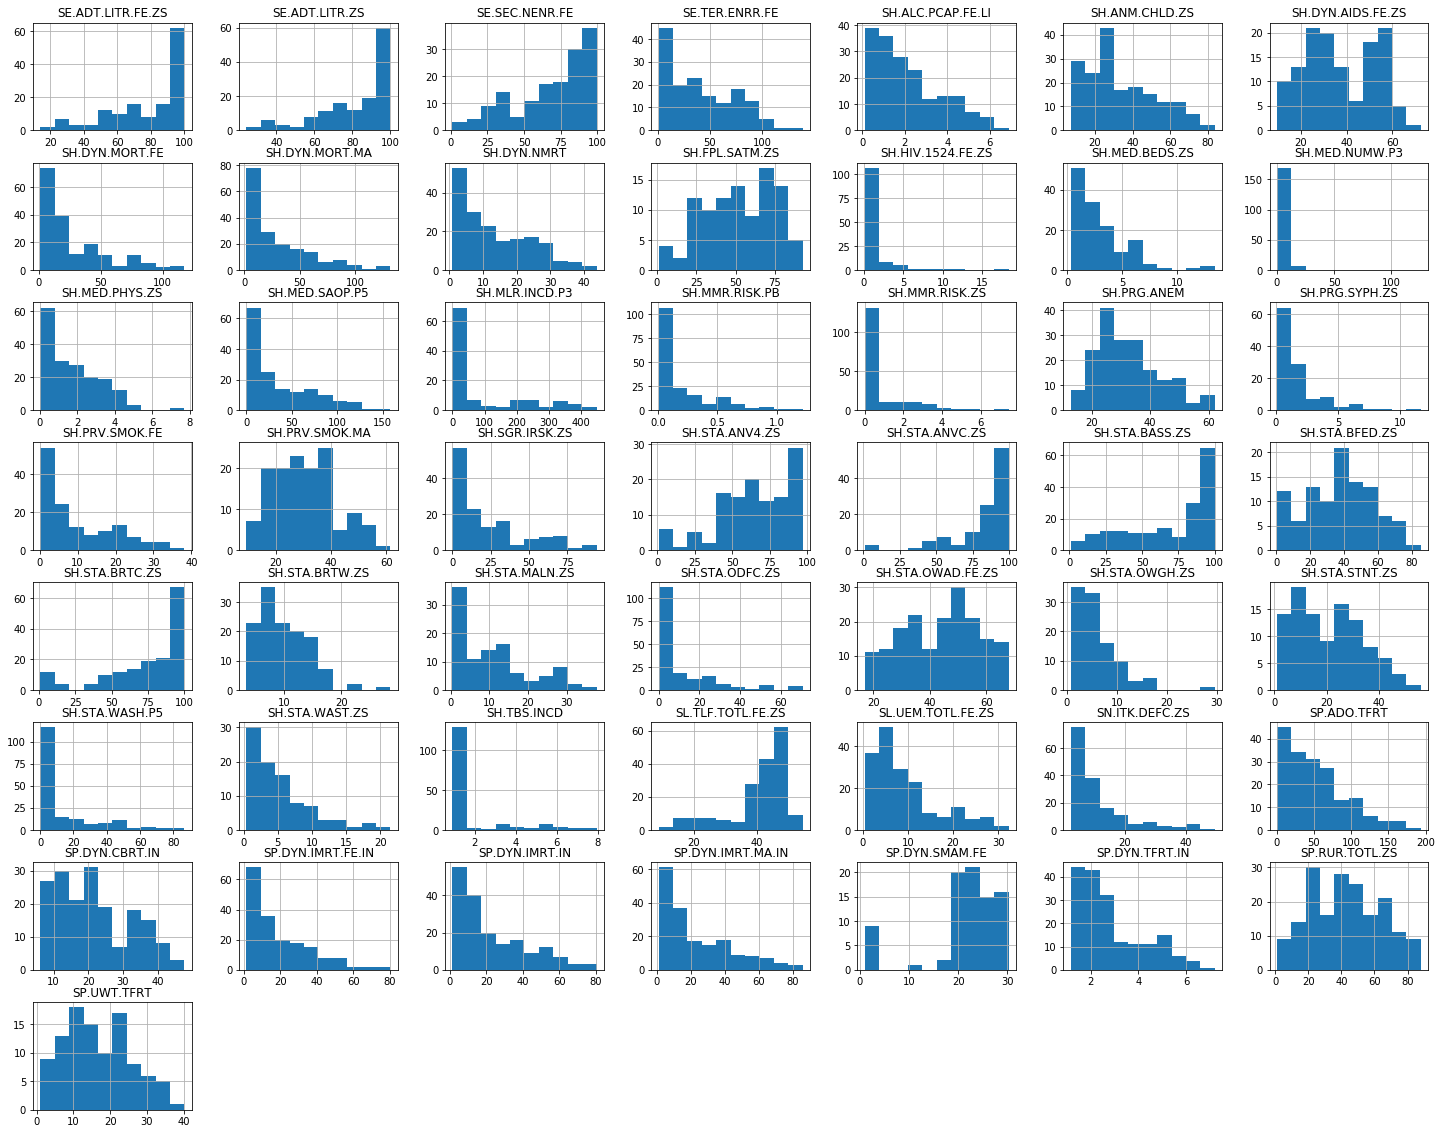

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
train_set.hist(figsize=(25,20))
plt.show()

Scatter plots of dependent variables between each other:

In [26]:
indicator_codes[indicator_codes['series_code'] == "SH.MMR.RISK.ZS"]

,Unnamed: 0,series_code,topic,indicator_name,short_definition
282,282.0,SH.MMR.RISK.ZS,"Health: ""Reproductive health","Lifetime risk of maternal death (%)""",NaN


In [27]:
indicator_codes[indicator_codes['series_code'] == "SP.DYN.IMRT.IN"]

,Unnamed: 0,series_code,topic,indicator_name,short_definition
278,278.0,SP.DYN.IMRT.IN,Health: Mortality,"Mortality rate, infant (per 1,000 live births)",NaN


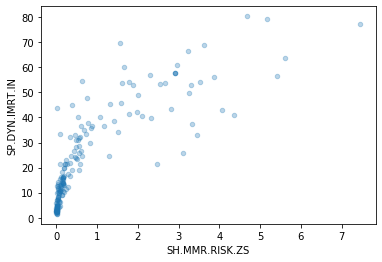

In [28]:
train_set.plot(kind="scatter", x="SH.MMR.RISK.ZS", y="SP.DYN.IMRT.IN", alpha=0.3)

In [29]:
indicator_codes[indicator_codes['series_code'] == "SH.DYN.NMRT"]

,Unnamed: 0,series_code,topic,indicator_name,short_definition
271,271.0,SH.DYN.NMRT,Health: Mortality,"Mortality rate, neonatal (per 1,000 live births)",NaN


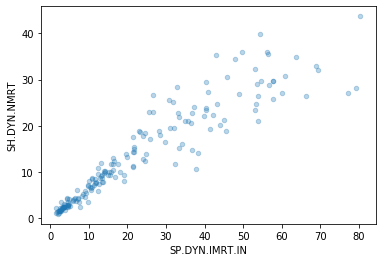

In [30]:
train_set.plot(kind="scatter", x="SP.DYN.IMRT.IN", y="SH.DYN.NMRT", alpha=0.3)

Some countries show gender disparity in child mortality rate:

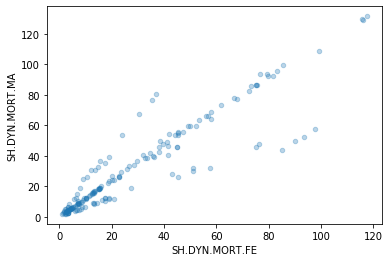

In [31]:
train_set.plot(kind="scatter", x="SH.DYN.MORT.FE", y="SH.DYN.MORT.MA", alpha=0.3)

This is also seen in infant mortality rate:

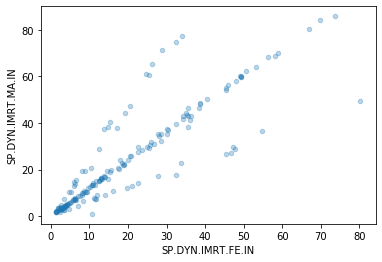

In [33]:
train_set.plot(kind="scatter", x="SP.DYN.IMRT.FE.IN", y="SP.DYN.IMRT.MA.IN", alpha=0.3)

In [34]:
train_set[train_set["SP.DYN.IMRT.MA.IN"]/train_set["SP.DYN.IMRT.FE.IN"] < 2/3.]["Country_Name"]

109                   Mauritius
31                      Ukraine
28                   Mauritania
42                 Burkina Faso
152                    Djibouti
78                    Indonesia
46                        India
22                     Colombia
194                  Low income
39        Sao Tome and Principe
3      Central African Republic
207                       World
34                         Iraq
8                        Mexico
52                    Nicaragua
Name: Country_Name, dtype: object

In [35]:
train_set[train_set["SP.DYN.IMRT.MA.IN"]/train_set["SP.DYN.IMRT.FE.IN"] > 4/3.]["Country_Name"]

66                 Kiribati
119               Argentina
95                  Lesotho
29                 Cambodia
56          Solomon Islands
155               Singapore
178                  Norway
51                  Eritrea
0         Brunei Darussalam
90                    Gabon
176                 Ireland
126                 Jamaica
201              South Asia
172               Australia
150             Netherlands
81                  Moldova
145                  Canada
53         Congo, Dem. Rep.
173                   Japan
49        Equatorial Guinea
80                  Liberia
89               Cabo Verde
72               Uzbekistan
54                 Zimbabwe
88                 Pakistan
37               Mozambique
130    United Arab Emirates
151                  Sweden
99       Iran, Islamic Rep.
116               Lithuania
87            Venezuela, RB
14              Gambia, The
102                    Peru
Name: Country_Name, dtype: object

Scatter plots of dependent variables vs selected independent variables show expected trends:

In [36]:
indicator_codes[indicator_codes["series_code"] == "SE.ADT.LITR.ZS"]

,Unnamed: 0,series_code,topic,indicator_name,short_definition
78,78.0,SE.ADT.LITR.ZS,Education: Outcomes,"Literacy rate, adult total (% of people ages 1...",NaN


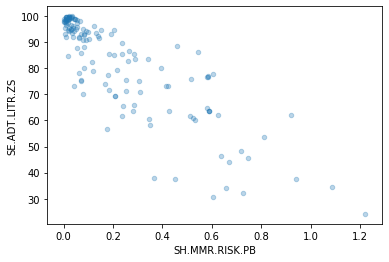

In [37]:
train_set.plot(kind="scatter", x="SH.MMR.RISK.PB", y="SE.ADT.LITR.ZS", alpha=0.3)

In [38]:
indicator_codes[indicator_codes["series_code"] == "SE.TER.ENRR.FE"]

,Unnamed: 0,series_code,topic,indicator_name,short_definition
95,95.0,SE.TER.ENRR.FE,Education: Participation,"School enrollment, tertiary, female (% gross)",NaN


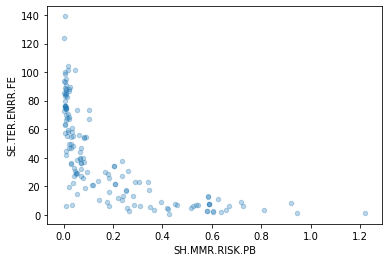

In [39]:
train_set.plot(kind="scatter", x="SH.MMR.RISK.PB", y="SE.TER.ENRR.FE", alpha=0.3)

In [40]:
indicator_codes[indicator_codes["series_code"] == "SH.STA.ANV4.ZS"]

,Unnamed: 0,series_code,topic,indicator_name,short_definition
117,117.0,SH.STA.ANV4.ZS,Health: Reproductive health,Pregnant women receiving prenatal care of at l...,NaN


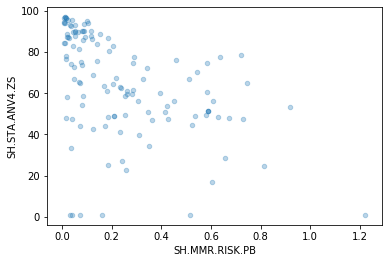

In [41]:
train_set.plot(kind="scatter", x="SH.MMR.RISK.PB", y="SH.STA.ANV4.ZS", alpha=0.3)

Calculate correlations coefficients of independent variables with per-birth maternal mortality risk:

In [42]:
train_set.corr()["SH.MMR.RISK.PB"].sort_values(ascending=True)

SE.SEC.NENR.FE      -0.845026
SE.ADT.LITR.ZS      -0.842730
SE.ADT.LITR.FE.ZS   -0.822202
SH.STA.BASS.ZS      -0.757396
SE.TER.ENRR.FE      -0.689883
SH.MED.PHYS.ZS      -0.653618
SH.MED.SAOP.P5      -0.575173
SH.STA.OWGH.ZS      -0.493402
SH.PRV.SMOK.FE      -0.477218
SH.STA.OWAD.FE.ZS   -0.465869
SH.STA.ANV4.ZS      -0.462680
SH.MED.BEDS.ZS      -0.436043
SH.STA.BRTC.ZS      -0.346697
SH.TBS.INCD         -0.312561
SH.PRV.SMOK.MA      -0.294835
SH.FPL.SATM.ZS      -0.289327
SH.ALC.PCAP.FE.LI   -0.288664
SH.MED.NUMW.P3      -0.247198
SH.STA.ANVC.ZS      -0.173145
SL.UEM.TOTL.FE.ZS   -0.150885
SP.DYN.SMAM.FE      -0.112927
SH.STA.BFED.ZS       0.053283
SL.TLF.TOTL.FE.ZS    0.173179
SH.STA.WAST.ZS       0.255299
SH.HIV.1524.FE.ZS    0.276167
SP.UWT.TFRT          0.401973
SH.STA.MALN.ZS       0.471609
SH.PRG.SYPH.ZS       0.526317
SP.RUR.TOTL.ZS       0.549387
SH.PRG.ANEM          0.577179
SH.STA.STNT.ZS       0.582118
SH.STA.BRTW.ZS       0.610377
SN.ITK.DEFC.ZS       0.662966
SH.STA.ODF

Split independent and dependent variable:

In [43]:
train_labels = train_set[['SP.DYN.IMRT.IN','SH.DYN.MORT.MA','SH.DYN.MORT.FE','SP.DYN.IMRT.MA.IN',
                          'SP.DYN.IMRT.FE.IN','SH.DYN.NMRT','SH.MMR.RISK.ZS','SH.MMR.RISK.PB']].copy()

test_labels = test_set[['SP.DYN.IMRT.IN','SH.DYN.MORT.MA','SH.DYN.MORT.FE','SP.DYN.IMRT.MA.IN',
                          'SP.DYN.IMRT.FE.IN','SH.DYN.NMRT','SH.MMR.RISK.ZS','SH.MMR.RISK.PB']].copy()

train_set_num = train_set.drop('Country_Name', axis=1)

train_set_num = train_set_num.drop(['SP.DYN.IMRT.IN','SH.DYN.MORT.MA','SH.DYN.MORT.FE','SP.DYN.IMRT.MA.IN',
                          'SP.DYN.IMRT.FE.IN','SH.DYN.NMRT','SH.MMR.RISK.ZS','SH.MMR.RISK.PB'], axis=1)

In [44]:
train_labels.isna().sum().sum()

0

Make a pipeline with a median imputer, train a random forest and calculate mean squared error for entire training set:

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # put different columns through different pipelines
from sklearn.impute import SimpleImputer # impute mean, median or constant to slots missing data
from sklearn.preprocessing import StandardScaler # scale to unit mean and variance

num_attribs = list(train_set_num)
#cat_attribs = 
#other_attribs = 

num_simple_pipeline = Pipeline([
        ('med_imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ])
#cat_pipeline = one-hot encoding, etc.

simple_pipeline = ColumnTransformer([("num",num_simple_pipeline, num_attribs),
                                   #("cat", cat_pipeline, cat_attribs), 
                                   #("dontouchit","passthrough",other_attribs),
                                   ])

train_simple = simple_pipeline.fit_transform(train_set)

In [46]:
isinstance(train_simple,np.ndarray)

True

In [47]:
np.shape(train_simple)

(179, 42)

In [48]:
isinstance(train_set,pd.DataFrame)

True

In [49]:
np.shape(train_set)

(179, 51)

Train a random forest regressor:

In [50]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=128, min_samples_split=2, min_samples_leaf=1)
forest_reg.fit(train_simple, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=128, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
from sklearn.metrics import mean_squared_error

forest_predictions = forest_reg.predict(train_simple)
forest_rmse = np.sqrt(mean_squared_error(train_labels, forest_predictions))
forest_rmse

3.504620577886576

In [52]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_simple, train_labels,
                                scoring="neg_mean_squared_error", cv=10) 
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores.mean(), forest_rmse_scores.std() #mean and standard deviation of the scores of k folds in k-fold cross-validation

(8.871437871558967, 2.6797682148956774)

Make a pipeline with iterative imputer using extra trees regressor and see if it reduces training error:

In [53]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor # Faster than random forests, does not use bootstrap sampling.

In [54]:
num_iterativeimpute_pipeline = Pipeline([
        ( 'itr_imputer', IterativeImputer(estimator= ExtraTreesRegressor(n_estimators=16)) ),
        ( 'std_scaler', StandardScaler() ),
        ])
#cat_pipeline = one-hot encoding, etc.

iterativeimpute_pipeline = ColumnTransformer([("num",num_iterativeimpute_pipeline, num_attribs),
                                   #("cat", cat_pipeline, cat_attribs), 
                                   #("dontouchit","passthrough",other_attribs),
                                   ])

train_iterativeimpute = iterativeimpute_pipeline.fit_transform(train_set_num)

/home/vj/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [55]:
forest_reg.fit(train_iterativeimpute, train_labels)
forest_predictions = forest_reg.predict(train_iterativeimpute)
forest_rmse_ = np.sqrt(mean_squared_error(train_labels, forest_predictions))
forest_rmse

3.504620577886576

In [56]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_iterativeimpute, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores.mean(), forest_rmse_scores.std() #mean and standard deviation of scores of the k cross-validation folds

(8.844148062180563, 2.565945084855532)

Now let's look at important features and select a good predictor subspace. Avoid PCA, LDA, etc because we don't want to sacrifice interpretability by rotating the axes in predictor space.  

In [57]:
forest_reg.feature_importances_

array([1.38250080e-02, 4.06419381e-03, 2.02315724e-02, 1.71142166e-02,
       3.16129839e-03, 1.40131524e-02, 4.44473570e-03, 3.44025553e-03,
       1.47553976e-02, 7.86849767e-03, 2.67595617e-03, 8.92744858e-05,
       8.71559392e-03, 1.53244121e-02, 1.89795962e-01, 5.73301659e-02,
       6.40519886e-03, 3.08103182e-03, 2.68149491e-03, 6.80477575e-03,
       1.03844506e-02, 4.30933335e-03, 5.36664049e-03, 3.83128694e-03,
       4.91142153e-03, 1.69945679e-03, 2.30213693e-03, 2.53472676e-03,
       5.11111403e-03, 3.68242277e-01, 4.43087148e-03, 1.69981900e-02,
       1.99089709e-03, 5.35421129e-03, 1.15798955e-01, 2.54384419e-03,
       2.98907302e-03, 3.23562479e-02, 4.78277182e-03, 2.87920584e-03,
       2.53547668e-03, 2.82521742e-03])

In [59]:
select_importantcols = []
for i in range(len(forest_reg.feature_importances_)):
    if (forest_reg.feature_importances_[i] > 6.0e-03):
        select_importantcols.append(i+1) #The column index is shifted by 1 because 0th column "Country_Name" isn't a feature.

In [60]:
importantcols_pipeline = ColumnTransformer([("num",num_simple_pipeline, mch.columns[select_importantcols]),
                                   #("cat", cat_pipeline, cat_attribs), 
                                   #("dontouchit","passthrough",other_attribs),
                                   ])

train_importantcols = importantcols_pipeline.fit_transform(train_set)

Unlike RandomForestRegressor, SVR and Linear Regression do not support multi-target regression natively, i.e. they do not refit parameters for each target but instead perform simultaneous regression for multiple outputs. Use the multioutput meta-estimator for these and compare training errors regression methods. 

In [61]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

linear_reg = MultiOutputRegressor(LinearRegression())
sv_reg10 = MultiOutputRegressor(SVR(kernel='rbf', degree=3, C=10.)) #Large C --> weak regularization --> hard fitting
sv_reg100 = MultiOutputRegressor(SVR(kernel='rbf', degree=3, C=100.)) #Even larger C --> weaker regularization --> harder fitting

forest_reg.fit(train_simple, train_labels)
forest_rmse_ = np.sqrt(mean_squared_error(train_labels, forest_reg.predict(train_simple)))

linear_reg.fit(train_simple, train_labels)
linear_reg_rmse = np.sqrt(mean_squared_error(train_labels, linear_reg.predict(train_simple)))

sv_reg10.fit(train_simple, train_labels)
sv_reg10_rmse = np.sqrt(mean_squared_error(train_labels,sv_reg10.predict(train_simple)))

sv_reg100.fit(train_simple, train_labels)
sv_reg100_rmse = np.sqrt(mean_squared_error(train_labels, sv_reg100.predict(train_simple)))

forest_rmse, linear_reg_rmse, sv_reg10_rmse, sv_reg100_rmse

(3.504620577886576, 6.929170798562845, 7.8704962543989385, 1.4793351206161)

Compare cross validation scores:

In [62]:
forest_scores = cross_val_score(forest_reg, train_simple, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores.mean(), forest_rmse_scores.std() #mean and standard deviation of the scores of k folds in k-fold cross-validation

(8.93542883525393, 2.6639408579162174)

In [63]:
linear_scores = cross_val_score(linear_reg, train_simple, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
linear_rmse_scores = np.sqrt(-linear_scores)
linear_rmse_scores.mean(), linear_rmse_scores.std() #mean and standard deviation of the scores of k folds in k-fold cross-validation

(11.200876186386347, 2.624944670204674)

In [64]:
sv_scores = cross_val_score(sv_reg10, train_simple, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
sv_rmse_scores = np.sqrt(-sv_scores)
sv_rmse_scores.mean(), sv_rmse_scores.std() #mean and standard deviation of the scores of k folds in k-fold cross-validation

(10.071293468034451, 2.4545320440437055)

In [65]:
sv_scores = cross_val_score(sv_reg100, train_simple, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
sv_rmse_scores = np.sqrt(-sv_scores)
sv_rmse_scores.mean(), sv_rmse_scores.std() #mean and standard deviation of the scores of k folds in k-fold cross-validation

(9.687184772306784, 2.316908484584225)

In [66]:
test_simple = simple_pipeline.fit_transform(test_set) #use same data preparation pipeline as was used for training set.

In [67]:
forest_predictions = forest_reg.predict(test_simple)
forest_rmse_simple = np.sqrt(mean_squared_error(test_labels, forest_predictions))
forest_rmse_simple

7.267003715852227

In [68]:
linear_reg_predictions = linear_reg.predict(test_simple)
linear_reg_rmse = np.sqrt(mean_squared_error(test_labels, linear_reg_predictions))
linear_reg_rmse

8.039270198807623

In [69]:
sv_reg10_predictions = sv_reg10.predict(test_simple)
sv_reg10_rmse = np.sqrt(mean_squared_error(test_labels, sv_reg10_predictions))
sv_reg10_rmse

8.604129269065622

In [70]:
sv_reg100_predictions = sv_reg100.predict(test_simple)
sv_reg100_rmse = np.sqrt(mean_squared_error(test_labels, sv_reg100_predictions))
sv_reg100_rmse

7.801843577831305

In [71]:
forest_reg.score(test_simple,test_labels), linear_reg.score(test_simple,test_labels), \
sv_reg10.score(test_simple,test_labels), sv_reg100.score(test_simple,test_labels) #The R^2 scores on test data:

/home/vj/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


(0.8323751717860006, 0.7697054136948637, 0.743743954706267, 0.7724264638246496)

Look at  training and cross validation errors for the selected predictor subspace selected by looking at feature importances:

In [72]:
forest_reg_importantcols = forest_reg.fit(train_importantcols, train_labels)
forest_reg_rmse = np.sqrt(mean_squared_error(train_labels, forest_reg_importantcols.predict(train_importantcols)))

linear_reg_importantcols = linear_reg.fit(train_importantcols, train_labels)
linear_reg_rmse = np.sqrt(mean_squared_error(train_labels, linear_reg_importantcols.predict(train_importantcols)))

sv_reg10_importantcols = sv_reg10.fit(train_importantcols, train_labels)
sv_reg10_rmse = np.sqrt(mean_squared_error(train_labels, sv_reg10_importantcols.predict(train_importantcols)))

sv_reg100_importantcols = sv_reg100.fit(train_importantcols, train_labels)
sv_reg100_rmse = np.sqrt(mean_squared_error(train_labels, sv_reg100_importantcols.predict(train_importantcols)))

forest_reg_rmse, linear_reg_rmse, sv_reg10_rmse, sv_reg100_rmse

(3.527153592070255, 7.875646197750743, 7.84213640683215, 2.5671719539033018)

In [73]:
forest_scores = cross_val_score(forest_reg_importantcols, train_importantcols, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores.mean(), forest_rmse_scores.std() #mean and standard deviation of scores of the k cross-validation folds

(8.673715984279278, 2.62282186827918)

In [74]:
linear_scores = cross_val_score(linear_reg_importantcols, train_importantcols, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
linear_rmse_scores = np.sqrt(-linear_scores)
linear_rmse_scores.mean(), linear_rmse_scores.std() #mean and standard deviation of the scores of k folds in k-fold cross-validation

(9.25064993275762, 1.7495540478045217)

In [75]:
sv_scores = cross_val_score(sv_reg10_importantcols, train_importantcols, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
sv_rmse_scores = np.sqrt(-sv_scores)
sv_rmse_scores.mean(), sv_rmse_scores.std() #mean and standard deviation of the scores of k folds in k-fold cross-validation

(9.615471722093037, 2.599473362330668)

In [76]:
sv_scores = cross_val_score(sv_reg100_importantcols, train_importantcols, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
sv_rmse_scores = np.sqrt(-sv_scores)
sv_rmse_scores.mean(), sv_rmse_scores.std() #mean and standard deviation of the scores of k folds in k-fold cross-validation

(9.376641940068192, 2.106556642692895)

Compare prediction errors for important predictor subspace:

In [77]:
test_importantcols = importantcols_pipeline.fit_transform(test_set)

In [78]:
forest_reg_importantcols.score(test_importantcols,test_labels), \
linear_reg_importantcols.score(test_importantcols,test_labels), \
sv_reg10_importantcols.score(test_importantcols,test_labels),    \
sv_reg100_importantcols.score(test_importantcols,test_labels) #The R^2 scores on test data:

/home/vj/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


(0.8481661215211199,
 0.8416796749396055,
 0.7623567053482179,
 0.8004186770762332)

RandomForestRegressor slightly outperforms Linear Regression and Support Vector Regressor by a slight margin on training, validation and test data. The selected subspace is more or less as predictive as the full pedictor space considered earlier. The important predictors are:

In [88]:
for string in mch.columns[select_importantcols]:
    print(indicator_codes[indicator_codes["series_code"] == string]["indicator_name"])

1    Prevalence of syphilis (% of women attending a...
Name: indicator_name, dtype: object
22    Birth rate, crude (per 1,000 people)
Name: indicator_name, dtype: object
26    Demand for family planning satisfied by modern...
Name: indicator_name, dtype: object
28    Specialist surgical workforce (per 100,000 pop...
Name: indicator_name, dtype: object
38    Adolescent fertility rate (births per 1,000 wo...
Name: indicator_name, dtype: object
46    Women's share of population ages 15+ living wi...
Name: indicator_name, dtype: object
76    Literacy rate, adult female (% of females ages...
Name: indicator_name, dtype: object
78    Literacy rate, adult total (% of people ages 1...
Name: indicator_name, dtype: object
92    School enrollment, secondary, female (% net)
Name: indicator_name, dtype: object
95    School enrollment, tertiary, female (% gross)
Name: indicator_name, dtype: object
101    Prevalence of undernourishment (% of population)
Name: indicator_name, dtype: object
118    Preg